# Variational AutoEncoder Fashion MNIST

Note: This notebook is designed to run with GPU runtime.

Import modules and set random seeds.

In [ ]:
import os, random, copy
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib import colormaps
import tensorflow as tf
from tensorflow.keras import layers, models, losses
from tensorflow.keras.datasets import fashion_mnist

random.seed(20230629)
np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Download the Fashion MNIST dataset and store into NumPy arrays.

In [ ]:
(train_images, train_labels), _ = fashion_mnist.load_data()
train_images = np.pad(train_images, ((0, 0), (2, 2), (2, 2)))
train_images = train_images.reshape(
                    (len(train_images), 32*32)).astype('float32') / 255
train_labels = tf.keras.utils.to_categorical(train_labels, 10)

labels = [np.argmax(label) for label in train_labels]
sample_images = np.array([train_images[labels.index(i)] for i in range(10)])

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Create labeled images to train the Variational AutoEncoder and the classification model simultaneously.

In [ ]:
labeled_images = np.hstack([train_images, train_labels])

Define the encoder with convolutional filters.

In [ ]:
encoder = models.Sequential(name='encoder')
encoder.add(layers.Input(shape=(32*32,), name='encoder_input'))
encoder.add(layers.Reshape((32, 32, 1), name='reshape'))
encoder.add(layers.Conv2D(32, (3, 3), strides=2, padding='same',
                activation='relu', name='conv_filter1')) # (16, 16, 32)
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same',
                activation='relu', name='conv_filter2')) # (8, 8, 64)
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same',
                activation='relu', name='conv_filter3')) # (4, 4, 128)
encoder.add(layers.Flatten(name='flatten'))
encoder.add(layers.Dense(4, name='mean_and_log_var'))

encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_filter1 (Conv2D)           │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_filter2 (Conv2D)           │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_filter3 (Conv2D)           │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mean_and_log_var (Dense)        │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

Define the sampler from the normal distribution.

In [ ]:
def get_samples(x): # x: encoder output
    num_examples = tf.shape(x)[0]
    means, log_vars = x[:, 0:2], x[:, 2:4]
    std_samples = tf.random.normal(shape=(num_examples, 2))
    samples = means + tf.exp(0.5 * log_vars) * std_samples
    return samples

sampler = models.Sequential(name='sampler')
sampler.add(layers.Input(shape=(4,), name='sampler_input'))
sampler.add(layers.Lambda(get_samples, name='sampled_embedding'))

sampler.summary()

Model: "sampler"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sampled_embedding (Lambda)      │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Define the decoder with transoposed convolutional filters.

In [ ]:
decoder = models.Sequential(name='decoder')
decoder.add(layers.Input(shape=(2,), name='decoder_input'))
decoder.add(layers.Dense(4 * 4 * 128, name='expand'))
decoder.add(layers.Reshape((4, 4, 128), name='reshape'))
decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same',
                activation='relu', name='conv_transpose1')) # (8, 8, 64)
decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same',
                activation='relu', name='conv_transpose2')) # (16, 16, 32)
decoder.add(layers.Conv2DTranspose(1, (3, 3), strides=2, padding='same',
                activation='sigmoid', name='conv_transpose3')) # (32, 32, 1)
decoder.add(layers.Flatten(name='flatten'))

decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ expand (Dense)                  │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_transpose1                 │ (None, 8, 8, 64)       │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_transpose2                 │ (None, 16, 16, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_transpose3                 │ (None, 32, 32, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,689 (385.50 KB)

 Trainable params: 98,689 (385.50 KB)

 Non-trainable params: 0 (0.00 B)

Define the discriminator as a linear classification model.

In [ ]:
discriminator = models.Sequential(name='discriminator')
discriminator.add(layers.Input(shape=(2,), name='discriminator_input'))
discriminator.add(layers.Dense(10, activation='softmax', name='softmax'))

discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ softmax (Dense)                 │ (None, 10)             │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30 (120.00 B)

 Trainable params: 30 (120.00 B)

 Non-trainable params: 0 (0.00 B)

Define the Variational AutoEncoder and the classification model by combining the components defined above.


In [ ]:
model_inputs = encoder.inputs[0]
model_outputs = layers.Concatenate(name='multi_task_output')(
    [encoder(model_inputs),                         # mean and log_var
     decoder(sampler(encoder(model_inputs))),       # reconstructed image
     discriminator(sampler(encoder(model_inputs)))  # label prediction
    ])

model = models.Model(inputs=model_inputs, outputs=model_outputs,
                     name='multi_task_model')
model.summary()

Model: "multi_task_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 4)         │    100,868 │ encoder_input[0]… │
│ (Sequential)        │                   │            │ encoder_input[0]… │
│                     │                   │            │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampler             │ (None, 2)         │          0 │ encoder[1][0],    │
│ (Sequential)        │                   │            │ encoder[2][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 1024)      │     98,689 │ sampler[0][0]     │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ discriminator       │ (None, 10)        │         30 │ sampler[1][0]     │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_task_output   │ (None, 1038)      │          0 │ encoder[0][0],    │
│ (Concatenate)       │                   │            │ decoder[0][0],    │
│                     │                   │            │ discriminator[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 199,587 (779.64 KB)

 Trainable params: 199,587 (779.64 KB)

 Non-trainable params: 0 (0.00 B)

Define the custom loss funtion to train two models simultaneously.



**一例として、分類モデルの誤差関数を加える重みを 0.02 から 0.2 に変更します。**

In [ ]:
def custom_loss(y_true, y_pred):
    mean, log_var = y_pred[:, 0:2], y_pred[:, 2:4]
    image_pred, label_pred = y_pred[:, 4:1028], y_pred[:, 1028:1038]
    image_true, label_true = y_true[:, 0:1024], y_true[:, 1024:1034]
    reconstruction_loss = losses.mse(image_true, image_pred)
    discriminator_loss = losses.CategoricalCrossentropy()(label_true, label_pred)
    kl_loss = tf.reduce_mean(tf.reduce_sum(
        -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var)), axis=1))
    loss = reconstruction_loss + 0.001 * kl_loss + 0.2 * discriminator_loss # この行を変更
    return loss

Compile the model using the Adam optimizer and the custom loss function.

In [ ]:
model.compile(optimizer='adam', loss=custom_loss)

Define a function to show reconstructed images.

In [ ]:
def show_result():
    results = model.predict(sample_images, verbose=0)[:, 4:1028]

    fig = plt.figure(figsize=(10, 2))
    for i in range(10):
        subplot = fig.add_subplot(2, 10, i+1)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(sample_images[i].reshape((32, 32)), interpolation='none',
                       vmin=0, vmax=1, cmap=plt.cm.gray_r)

        subplot = fig.add_subplot(2, 10, i+11)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(results[i].reshape((32, 32)), interpolation='none',
                       vmin=0, vmax=1, cmap=plt.cm.gray_r)

Train the model and show the result.

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.4102
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.2516
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2161
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1951
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1804
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1689
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1596
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1518
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1448
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1382
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1315
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1245
Epoch 13/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1186
Epoch 14/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.1133
Epoch 15/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step -

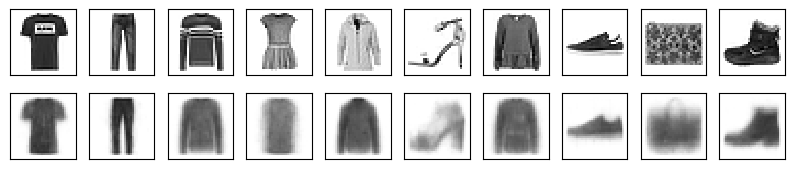

In [ ]:
%%time
history = model.fit(train_images, labeled_images,
                    batch_size=128, epochs=50)
show_result()

Show the embeddings of training data.

**潜在空間のデータ分布を見ると、ファッションアイテムごとのクラスターがより明確に分かれており、全体として、原点からより遠い部分までデータ広がっています。**

下記のコードでは、データの表示範囲を -8 〜 8 に広げている点に注意してください。

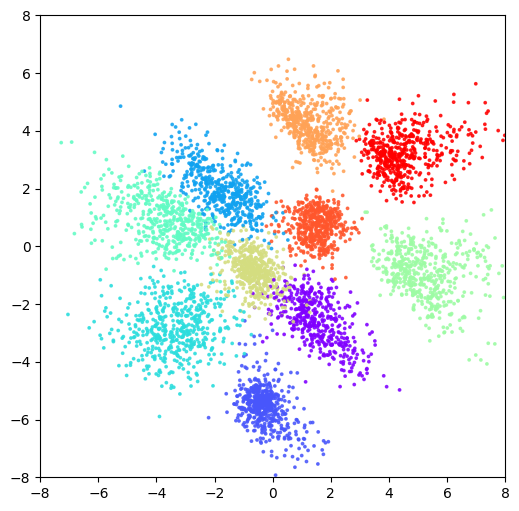

In [ ]:
embeddings = encoder.predict(train_images[:5000], verbose=0)
example_labels = np.argmax(train_labels[:5000], axis=1)

fig = plt.figure(figsize=(6, 6))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_xlim((-8, 8)) # この行を変更
subplot.set_ylim((-8, 8)) # この行を変更
_ = subplot.scatter(embeddings[:, 0], embeddings[:, 1],
                    cmap='rainbow', c=example_labels, alpha=0.8, s=3)

Show the embeddings of training data over the entire embedding space through a variable conversion with the sigmoid function.

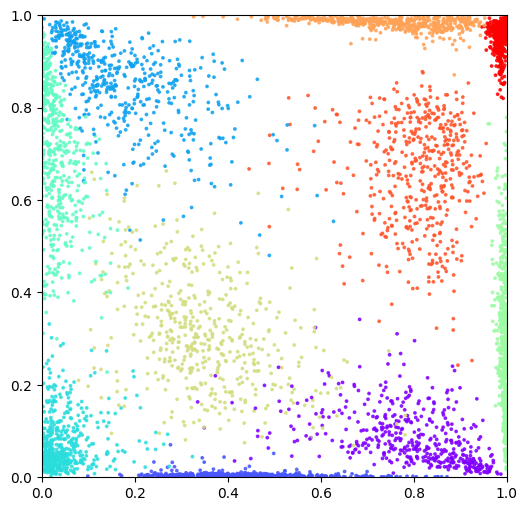

In [ ]:
fig = plt.figure(figsize=(6, 6))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_xlim((0, 1))
subplot.set_ylim((0, 1))
sigmoid = lambda x: 1/(1 + np.exp(-x))
_ = subplot.scatter(sigmoid(embeddings[:, 0]), sigmoid(embeddings[:, 1]),
                    cmap='rainbow', c=example_labels, alpha=0.8, s=3)

Show reconstruction images over the entire embedding space.

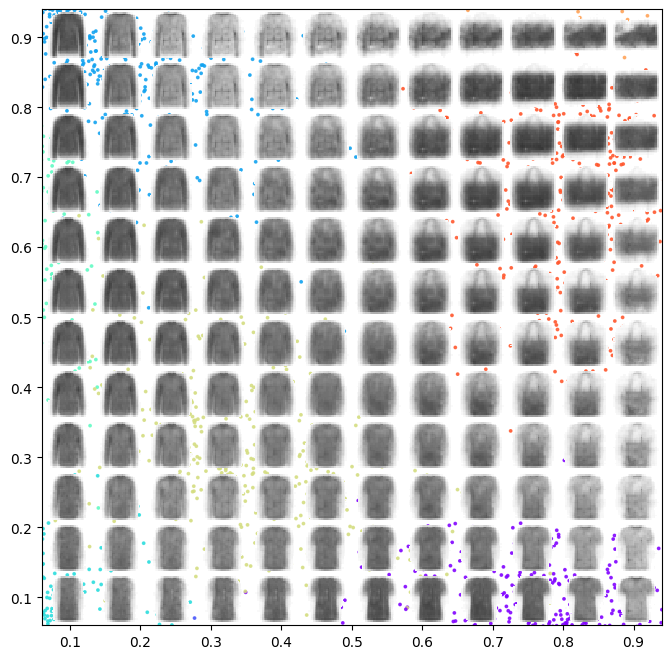

In [ ]:
x = np.linspace(0.1, 0.9, 12)
y = np.linspace(0.9, 0.1, 12)
xv, yv = np.meshgrid(x, y)
logit = lambda x: np.log(x)-np.log(1-x)
grid = np.array([*zip(logit(xv.flatten()), logit(yv.flatten()))])
reconstructions = decoder.predict(grid, verbose=0)

fig = plt.figure(figsize=(8, 8))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_xlim((0.06, 0.94))
subplot.set_ylim((0.06, 0.94))
subplot.scatter(sigmoid(embeddings[:, 0]), sigmoid(embeddings[:, 1]),
                cmap='rainbow', c=example_labels, alpha=0.8, s=3)

my_cmap = copy.copy(colormaps['gray_r'])
my_cmap.set_bad(alpha=0)
fig.subplots_adjust(hspace=0, wspace=0)
for i in range(12*12):
    subplot = fig.add_subplot(12, 12, i + 1)
    subplot.axis('off')
    # make background transparent
    img = [*map(lambda x: np.nan if x < 0.02 else x, reconstructions[i])]
    subplot.imshow(np.array(img).reshape((32, 32)), interpolation='none',
                   vmin=0, vmax=1, cmap=my_cmap)